In [1]:
import importlib
import dm_continuation_v2
importlib.reload(dm_continuation_v2)
# imports final propagated map from DM simulation

ModuleNotFoundError: No module named 'erfa'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift

<Figure size 800x1800 with 0 Axes>

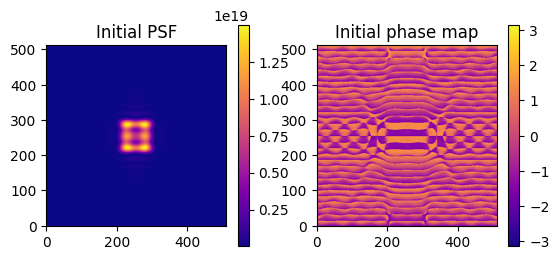

<Figure size 800x1800 with 0 Axes>

In [17]:
initial_wf = dm_continuation_v2.reflected_wf
initial_psf = np.abs(initial_wf)**2
initial_phase = np.angle((dm_continuation_v2.u2))

fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(initial_psf, origin='lower', cmap='plasma')
ax1.set_title("Initial PSF")

im2 = ax2.imshow(initial_phase, origin='lower', cmap='plasma')
ax2.set_title("Initial phase map")

fig.colorbar(im1, shrink=0.6)
fig.colorbar(im2, shrink = 0.6)
plt.figure(figsize=(8,18))

In [53]:
import segment_phasing_fp_env
import pripy
from pripy.algos import GerchbergSaxton as GS 
from tqdm import tqdm
import aotools
from aotools import zernike
import numpy as np
import matplotlib.pyplot as plt 
import torch as t
import scipy.interpolate as interp

256


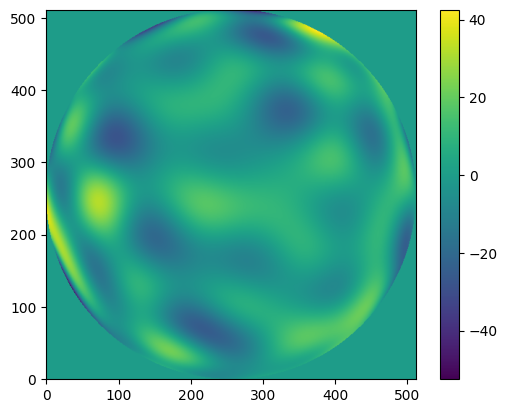

In [54]:
device = "cpu"

wvl = 200e-9
focal_length = 10
pix_size = 1e-5
pupil_radius_m = 5e-3
pupil_radius_p = 256 #int(pupil_radius_m/pix_size)
print(pupil_radius_p)

fft_width = 4*pupil_radius_p

pupil = t.tensor(aotools.phaseFromZernikes([1], 2*pupil_radius_p), dtype=t.float32, device=device)
max_zern = 100
zerns = t.tensor(aotools.zernikeArray(max_zern, 2*pupil_radius_p), dtype=t.float32, device=device)

def phase_from_zerns(x: t.tensor):
    if len(x.shape)==1:
        return t.einsum("ijk,i->jk", zerns, x)
    else:
        return t.einsum("ijk,...i->...jk", zerns, x)

x_ell = t.randn(max_zern, device=device)
plt.imshow(phase_from_zerns(x_ell).cpu(), origin = 'lower')
plt.colorbar()


Text(0, 0.5, 'Mode value')

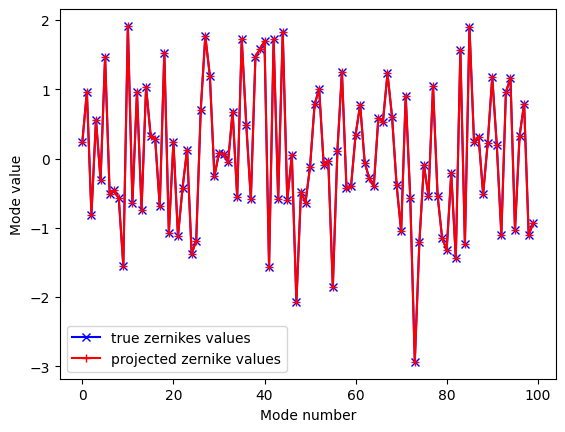

In [56]:
z = zerns[:,pupil==1].T
p2z = t.linalg.solve(z.T @ z, z.T)
plt.figure()
plt.plot(x_ell.cpu(), "bx-", label="true zernikes values")
plt.plot((p2z @ phase_from_zerns(x_ell)[pupil==1]).cpu(), "r+-", label="projected zernike values")
plt.legend()
plt.xlabel("Mode number")
plt.ylabel("Mode value")

In [ ]:
defocPoints = t.linspace(0.5*focal_length, 1.5*focal_length, 1, device=device)
num_points = defocPoints.shape[0]
x_points = t.randn(*[num_points, max_zern], device = device)*4e-3

def phase_at_layer(x: t.tensor, defocPoint: float, wavelength = wvl, pupil_radius_m=pupil_radius_m):
    import numpy as np
    phi = phase_from_zerns(x).cpu().numpy()
    # original code uses star position tomography instead of defocus, so requires adjusting
    
    yy, xx = np.mgrid[:2*pupil_radius_p, :2*pupil_radius_p] * 1.0
    
    scaling_factor = pupil_radius_m/pupil_radius_p
    xx = (xx-pupil_radius_p)*scaling_factor
    yy = (yy-pupil_radius_p)*scaling_factor

    phi_defoc = phi + (np.pi/(wavelength*defocPoint))*(xx**2+yy**2)
    return phi_defoc



<class 'numpy.ndarray'>


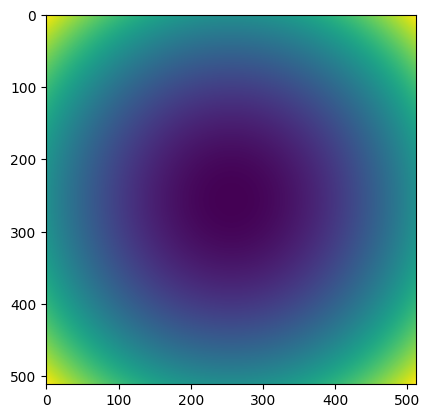

In [65]:
phase_defoc = phase_at_layer(x_points[0], defocPoint=5)
plt.imshow(phase_defoc)

In [68]:
def phase_in_direction(x):
    stacked = np.stack(
        [phase_at_layer(xi, defocPoint)[None, ...] for xi, defocPoint in zip(x, defocPoints)],
        axis=0
    )
    return stacked.sum(axis=0) * pupil

plt.imshow(phase_in_direction(x_points))

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.